#  Data pre-processing and augmentation 

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch
import torchvision
import PIL

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

print(device)

cuda


In [2]:
class UnlabeledDataset(Dataset):
    """Custom Unlabeled DataSet class for melanoma classification model"""
    
    def __init__(self, dir_path, transform=None):
        """
        Args:
        dir_pat (strin): path to direcory containing the images
        transform (optional): optional transform to be applied
        
        """
        self.dir_path = dir_path
        self.transform = transform
        
        
    def __len__(self):
        """Finds out the total number of samples"""
        list = os.listdir(self.dir_path)
        return len(list)
    
    def __getitem__(self, i):
        """Import image and transform to tensor.
           Since files in a directory are not inherently 
           sorted in a particular way need to grab the 
           file names, sort the file names in ascending order.
        """
        
        def sort_input_files(self):
        
            file_list = os.listdir(self.dir_path) 
            file_name_list=[int(file.split(".")[0]) for file in file_list]
            sorted_files =[str(file) + '.jpg' for file in sorted(file_name_list)]
            return sorted_files
        
        img_file = sort_input_files(self)[i]
        img = Image.open(self.dir_path + img_file)
        
        img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img
                

In [3]:
class LabeledDataset(Dataset):
    """Custom Labeled DataSet class for melanoma classification model"""
    
    def __init__(self, dir_path, transform=None):
        """
        Args:
        dir_pat (strin): path to direcory containing the images
        transform (optional): optional transform to be applied
        
        """
        self.dir_path = dir_path
        self.transform = transform
        
        
    def __len__(self):
        """Finds out the total number of samples"""
        list = os.listdir(self.dir_path) 
        return len(list)
    
    def __getitem__(self, i):
        """Import image, get its label and transform to tensor.
           Since files in a directory are not inherently 
           sorted in a particular way need to grab the 
           file names, sort the file names by ascending order.
        """
        
        def sort_input_files(self):
        
            file_list = os.listdir(self.dir_path) 
            
            separator = "_"
            file_names=[]
            file_exts=[]
            for file in file_list:
                file_names.append(int(file.split("_")[0]))
                file_exts.append(file.split("_")[1])
            
            sorted_files =[str(name) + separator + ext for (name, ext) in sorted(zip(file_names, file_exts))]
            return sorted_files
        
        def get_label(file_name):
            #extract the 5th character from the end of the file name
            file_ext = file_name[-5:-4]
            return ["benign","malignant"][int(file_ext) > 0]  
        
        img_file = sort_input_files(self)[i]
        label = get_label(img_file) 
                     
        img = Image.open(self.dir_path + img_file)
        
        img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, label
                

In [4]:
#set path to data folders
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))

unlabeled_data_path = os.path.join(path, parent, 'Data/unlabeled/')
labeled_data_path = os.path.join(path, parent, 'Data/labeled/')

In [5]:
# transform PIL image into a 5D Torch tensor, scaled in [0,1]
transform = transforms.ToTensor()

unlabeled_dataset = UnlabeledDataset(dir_path= unlabeled_data_path, transform=transform)
labeled_dataset  = LabeledDataset(dir_path= labeled_data_path, transform=transform)

In [6]:
print("number of unlabeled images:", len(unlabeled_dataset))
print("nnumber of labeled images:",  len(labeled_dataset))

number of unlabeled images: 7018
nnumber of labeled images: 200


In [7]:
def display_random_img(dataset):
    
    i = random.randint(0, len(dataset)-1)

    if len(dataset[i]) > 2:
        sample = dataset[i]
        plt.title("Unlabeled")
    else:
        sample, label = dataset[i] 
        plt.title(label)

    #permute the tensor to put the channel as the last dimension in order to plot
    plt.imshow(sample.permute(1, 2, 0)) 
    plt.show()

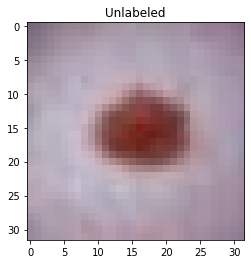

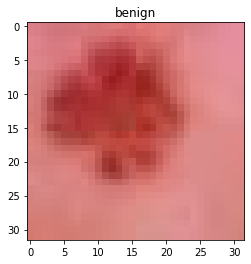

In [8]:
display_random_img(unlabeled_dataset)
display_random_img(  labeled_dataset)

In [9]:
# DataLoader is an iterator that provides batching, shuffling and parallel loading of the data 
# copy tensors into CUDA before returning them with setting pin_memory=True
unlabeled_dataloader = DataLoader(unlabeled_dataset, 
                                  batch_size = 16,
                                  shuffle = True, 
                                  num_workers = 0,
                                  pin_memory=True)



labeled_dataloader = DataLoader(labeled_dataset, 
                                batch_size = 16,
                                shuffle = True, 
                                num_workers = 0,
                                pin_memory=True)

In [10]:
def get_batch_dims(batch):
    """ Helper function returning returning the batch number, 
        the images within the batch and their labels if labeled. """ 
    
    batch_idx = batch[0]
    
    if len(batch[1])==2:
        
        images = batch[1][0]
        labels = batch[1][1]
        batch_size = len(images)
        
    else:
        
        images = batch[1]
        batch_size = len(images)
        labels = [" "] * batch_size
        
    return batch_idx, images, labels

In [13]:
def show_batch_images(sample_batch, nrows=4, ncols=4):
    """ Helper function for displaying images in one batch """
    
    batch_idx, images, labels = get_batch_dims(sample_batch) 
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
    fig.suptitle("Images of batch number {}".format(batch_idx), fontsize=14)
    
    n = 0 
    for i in range(nrows):
        
        for j in range(ncols): 
            
            axes[i,j].imshow(images[i + j + (ncols-1)*n].permute(1, 2, 0))
            axes[i,j].set_title(labels[i + j + (ncols-1)*n], fontsize=10)
            axes[i,j].axis('off')
        
        n += 1

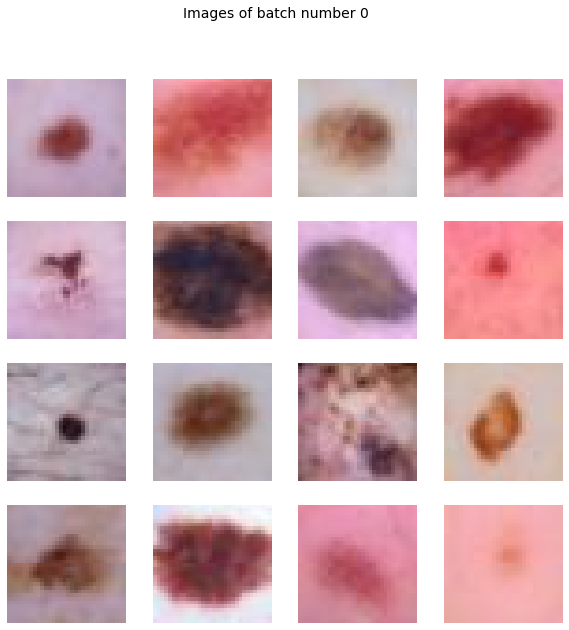

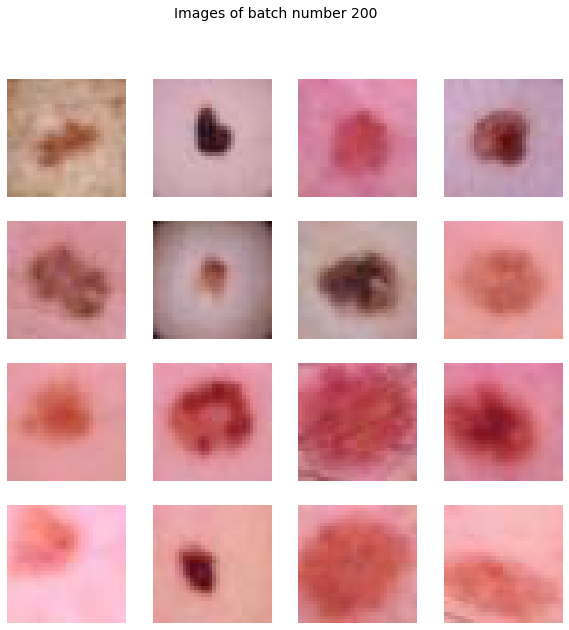

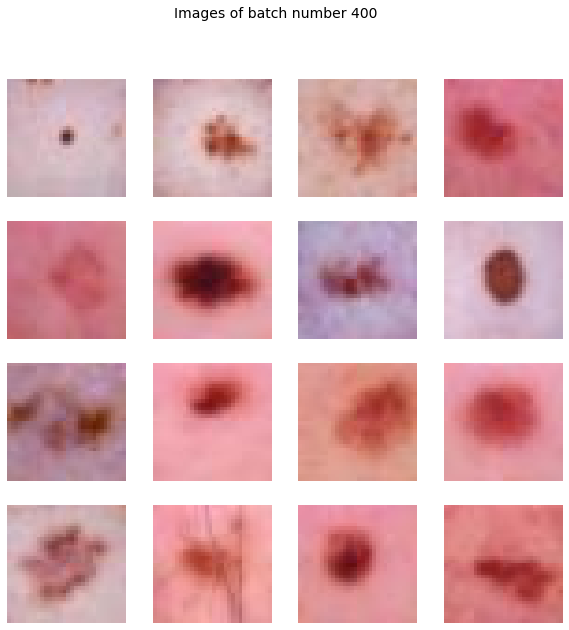

In [14]:
for sample_batch in enumerate(unlabeled_dataloader):
    
    batch_idx = sample_batch[0]
    
    if batch_idx % 200 == 0:
        show_batch_images(sample_batch)

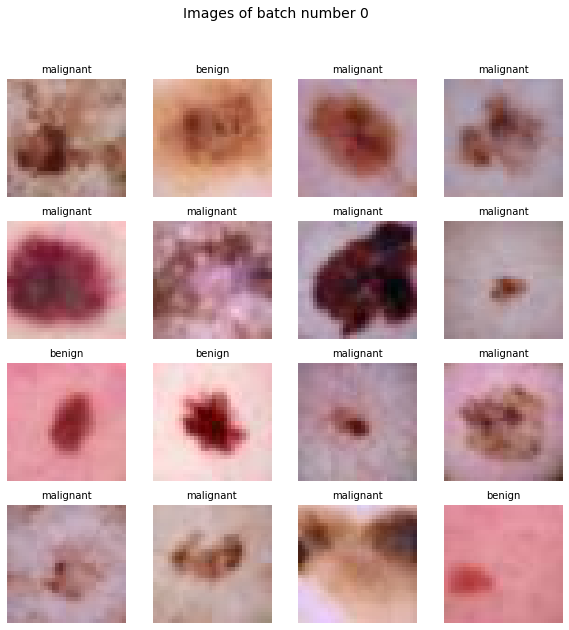

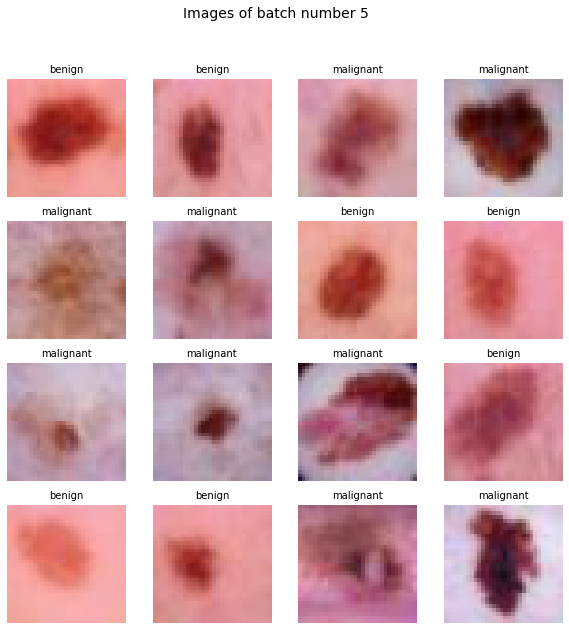

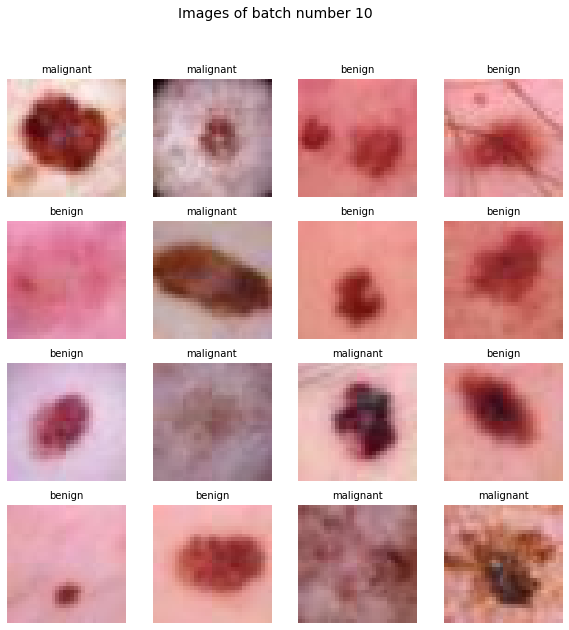

In [15]:
for sample_batch in enumerate(labeled_dataloader):
    
    batch_idx = sample_batch[0]
    
    if batch_idx % 5 == 0:
        show_batch_images(sample_batch)

In [16]:
def get_norm_parameters(dataset): 
    """ Function computing the mean and std for each chanel across the dataset 
        after stacking the tensors of the dataset """

    if len(dataset[0]) > 2:    
        imgs = torch.stack([img_tensor for img_tensor in dataset], dim=3)
        
    else: 
        imgs = torch.stack([img_tensor for img_tensor, _ in dataset], dim=3)

    #keep the RBG channels and merge the rest of the dims, 3x32x32 is transformed into 3x1024 
    mean = imgs.view(3, -1).mean(dim=1)
    std  = imgs.view(3, -1).std(dim=1)
    
    return mean, std

In [17]:
unlabeled_mean, unlabeled_std = get_norm_parameters(unlabeled_dataset)
labeled_mean, labeled_std     = get_norm_parameters(labeled_dataset)

print("unlabeled data normalizing mean {} and std {} parameter.".format(unlabeled_mean, unlabeled_std))
print("labeled data normalizing mean {} and std {} parameter.".format(labeled_mean, labeled_std) )

unlabeled data normalizing mean tensor([0.7722, 0.5286, 0.5501]) and std tensor([0.1399, 0.1602, 0.1772]) parameter.
labeled data normalizing mean tensor([0.7441, 0.5331, 0.5548]) and std tensor([0.1464, 0.1557, 0.1735]) parameter.


In [18]:
# Initialize the Normalize transform with the datasets mean and std values
unl_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean = unlabeled_mean,
                                                               std = unlabeled_std)])
 
unlabeled_dataset = UnlabeledDataset(dir_path= unlabeled_data_path, transform=unl_transform)

In [19]:
#augment the labeled data by applying randomly a list of transformations with given probability
augm_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(0,360),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = labeled_mean,
                                                          std = labeled_std)])
all_datasets = []
for counter in range(len(unlabeled_dataset)//len(labeled_dataset)):
    
    transformed_dataset = LabeledDataset(dir_path= labeled_data_path, transform=augm_transform)
    all_datasets.append(transformed_dataset)
    counter += 1
    
augmented_labeled_dataset = torch.utils.data.ConcatDataset(all_datasets)  

print("augmented data contains {} labeled images.".format(len(augmented_labeled_dataset)))

augmented data contains 7000 labeled images.


In [20]:
#initialize the dataloaders with the normalized and augmented data sets
unlabeled_dataloader = DataLoader(unlabeled_dataset, 
                                  batch_size = 16,
                                  shuffle = True, 
                                  num_workers = 0,
                                  pin_memory=True)

labeled_dataloader = DataLoader(augmented_labeled_dataset, 
                                batch_size = 16,
                                shuffle = True, 
                                num_workers = 0,
                                pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


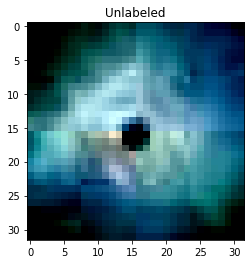

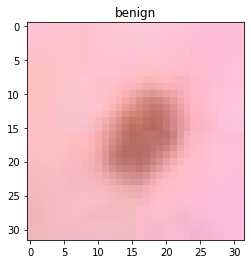

In [21]:
#The normalization has shifted the RGN levels outside the [0,1] range and chenged the overall magnitudes of the channels
display_random_img(unlabeled_dataset)
display_random_img(  labeled_dataset)